# Epsilon Greedy

In [1]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from collections import namedtuple
import random
from Arm import Arm
from runner import graph_impressions, run_round, graph_regret, display_real_ctrs

## Basics

Epsilon Greedy sets an explicit proportion of the time it should exploit vs explore. For example, when choosing an arm, you can say: choose the arm we think is best 90% of the time, and 10% of the time, let's explore and confirm our assumption about what is best.

In [2]:
class EpsilonGreedyArm(Arm):
    def __init__(self, name, expected_win_rate):
        super(EpsilonGreedyArm, self).__init__(name, expected_win_rate)
        

## Choosing an arm

Here, we pass an epsilon value between 0 and 1. When we want to choose an arm, we grab a random number. If it's greater than epsilon, we exploit. If it's less than epsilon, we explore.

In [3]:

def exploit_or_explore(epsilon):
    """ True if exploit, False if explore"""
    return epsilon < random.random()

def get_winning_arm(arms):
    max_win_rate = max([a.win_rate for a in arms])
    winners = [arm for arm in arms 
                  if arm.win_rate == max_win_rate]

    return random.choice(winners)

def choose_arm(epsilon):
    assert 0 <= epsilon <= 1
    def _choose_arm(arms):
        use_winner = exploit_or_explore(epsilon)

        if use_winner:
            return get_winning_arm(arms)
        return random.choice(arms)

    return _choose_arm
    
    

Choosing an arm 100 times, unsurprisingly, shows that for an epsilon of 0.1, we explore ~10% of the time and exploit 90%. 

In [4]:
CHOOSE_ARM_N_TIMES = 100
def example_arm_choice(epsilon):
    # Choose arms 100 times, so we can see how exploring/exploiting works
    explore = 0
    exploit = 0
    
    for _ in range(CHOOSE_ARM_N_TIMES):
        chose_winner = exploit_or_explore()
        explore += not chose_winner
        exploit += chose_winner
        
    sns.lineplot(data=pd.DataFrame(data={'explore': explore, 'exploit': exploit}, index=[1]))
        
widget = interact_manual(example_arm_choice, 
                     epsilon=widgets.FloatSlider(step=0.1, value=0.1, max=1, continuous_update=False));
widget

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='epsilon', max=1.0), Button(…

<function __main__.example_arm_choice(epsilon)>

In [7]:
def run(num_events, probs, epsilon):
    prob_list = [float(i.strip()) for i in probs.split(',')]
    RUN_N_TRIALS = 100
    
    arms = [EpsilonGreedyArm(str(prob), prob) for prob in prob_list]
    
    trials = []
    for _ in range(RUN_N_TRIALS):
        arms_to_history = {arm: {'wins': [], 'impressions': []} for arm in arms}

        for i in range(num_events):
            arms_to_history = run_round(choose_arm(epsilon), arms_to_history)

        trials.append(arms_to_history)

    arms_to_history = {arm: {'wins': [], 'impressions': []} for arm in arms}
    for arm in arms:
        arms_to_history[arm]['wins'] = np.mean([trial[arm]['wins'] for trial in trials], axis=0)
        arms_to_history[arm]['impressions'] = np.mean([trial[arm]['impressions'] for trial in trials], axis=0)
        
    graph_impressions(arms_to_history)
    graph_regret(arms_to_history) 
    display_real_ctrs(arms_to_history)

## Drawbacks

The big issue with Epsilon Greedy may have occurred to you. What if there's a clear winner? Let's say we've chosen and pulled arms 1000 times. Of the three arms, one has a 20% action rate, while the others have a 1% or 2% rate. We go to choose an arm, and there's still a 10% chance that we pick one of the low-performing arms! Intuitively, we feel like we should have stopped exploring -- we have an answer -- but the algorithm keeps going. 
    
    

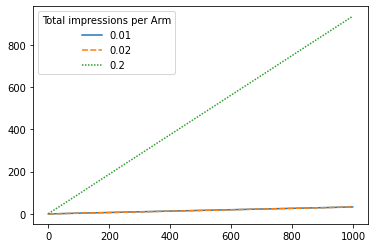

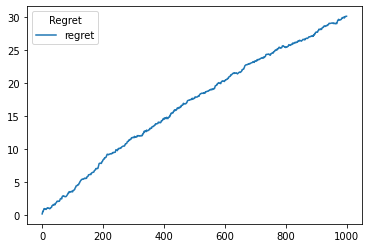

,Expected CTR,Actual CTR
0.01,1.0%,1.0%
0.02,2.0%,2.2%
0.2,20.0%,19.9%


In [8]:
arm_probabilities = '0.01, 0.02, 0.2'
epsilon = 0.1
run(1000, arm_probabilities, epsilon)

## Trying different parameters

Here, you can play with the number of events, different action rates, and different sizes of epsilon. 

In [9]:
widget = interact_manual(run, 
                     num_events=widgets.IntSlider(min=1, max=1000, step=1, value=10, continuous_update=False),
                     epsilon=widgets.FloatSlider(step=0.1, value=0.1, max=1, continuous_update=False),
                     probs=widgets.Text(
                        placeholder='Comma-sep floats',
                        description='Action Rate:',
                        value='0.05,0.075,0.1',
                        continuous_update=False
                    ));
widget



interactive(children=(IntSlider(value=10, continuous_update=False, description='num_events', max=1000, min=1),…

<function __main__.run(num_events, probs, epsilon)>